In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score

,Smile,Molecule
0,c1c2c(=O)c3c(c4[nH]c5c(c6c7c([nH]c6c6c(=O)c8c(...,

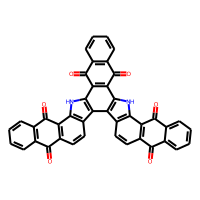

In [8]:
data = pd.read_csv('alldata_chemprop_random_nocanonical.csv')
data.head(1)
PandasTools.AddMoleculeColumnToFrame(data,'Smile','Molecule')
data[["Smile","Molecule"]].head(1)

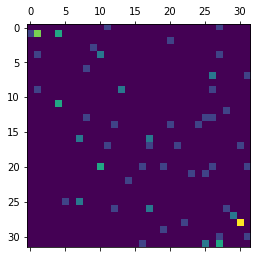

In [9]:
def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol,2,nBits=1024)
    ar = np.zeros((0,),dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp,ar)
    return ar

fp = mol2fp(Chem.MolFromSmiles(data.loc[1,"Smile"]))
plt.matshow(fp.reshape((32,-1)))

In [10]:
data["FPs"] = data.Molecule.apply(mol2fp)
x = np.stack(data.FPs.values)
y = data.Label.values.reshape((-1,1))

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.10,random_state=42)
x_train,x_validation,y_train,y_validation = train_test_split(x_train,y_train,test_size=0.1,random_state=42)
#scaler = StandardScaler()
#y_train = scaler.fit_transform(y_train)
#y_test = scaler.transform(y_test)
#y_validation = scaler.transform(y_validation)
from sklearn.feature_selection import VarianceThreshold
#from sklearn.preprocessing import StandardScaler
feature_select = VarianceThreshold(threshold=0.05)
#scaler = StandardScaler()
x_train = feature_select.fit_transform(x_train)
x_validation = feature_select.transform(x_validation)
x_test = feature_select.transform(x_test)
x_train.shape

(5269, 197)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

x_train = torch.FloatTensor(x_train)
x_test  = torch.FloatTensor(x_test)
x_validation = torch.FloatTensor(x_validation)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)
y_validation = torch.FloatTensor(y_validation)
x_train

cuda:0


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [13]:
class Traindata(Dataset):
    def __init__(self,x_data,y_data):
        self.x_data = x_data
        self.y_data = y_data
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    def __len__(self):
        return len(self.x_data)
train_data = Traindata(x_train,y_train)
train_data.__getitem__(3)

(tensor([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 6., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 3., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 5., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 8., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0.]))

In [14]:
epochs = 500
batch_size = 128
learning_rate = 0.001
train_loader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
#train_loader_iter = iter(train_loader)
#print(next(train_loader_iter))

In [15]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification,self).__init__()
        self.layer_1 = nn.Linear(197,256)
        #self.layer_2 = nn.Linear(512,256)
        self.layer_3 = nn.Linear(256,128)
        self.layer_out = nn.Linear(128,1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.8)
        self.ln_1 = nn.LayerNorm(256)
        #self.ln_2 = nn.LayerNorm(1024)
        self.ln_3 = nn.LayerNorm(128)
    
    def forward(self,inputs):
        x = self.layer_1(inputs)
        x = self.ln_1(x)
        x = self.relu(x)
        x = self.dropout(x)

        #x = self.layer_2(x)
        #x = self.ln_2(x)
        #x = self.relu(x)
        #x = self.dropout(x)

        x = self.layer_3(x)
        x = self.ln_3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer_out(x)

        return x

In [16]:
model = BinaryClassification()
model.to(device)

BinaryClassification(
  (layer_1): Linear(in_features=197, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.8, inplace=False)
  (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (ln_3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
)

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [18]:
def binary_acc(y_pred,y_test):
    y_pred_tags = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc*100)

    return acc

In [41]:
xxx = x_train[0:2]
print(xxx)
print(device)
xxx=xxx.to(device)
print(xxx)
yyy_pred = model(xxx)
yyy = y_train[0:2].to(device)
print(yyy_pred)
print(yyy)
print(criterion(yyy_pred,yyy.unsqueeze(1)))


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
cuda:0
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[-0.5699],
        [ 0.4519]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.],
        [1.]], device='cuda:0')


ValueError: Target size (torch.Size([2, 1, 1])) must be the same as input size (torch.Size([2, 1]))

In [19]:
model.train()
y_validation=y_validation.to(device)
x_validation=x_validation.to(device)
for e in range(1,epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    epoch_acc2 = 0
    for x_batch,y_batch in train_loader:
        x_batch,y_batch=x_batch.to(device),y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)

        loss = criterion(y_pred,y_batch)
        acc = binary_acc(y_pred,y_batch)

        y_validation_pred = model(x_validation)
        acc2 = binary_acc(y_validation_pred,y_validation)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_acc2 += acc2.item()

    print(f'Epoch {e+0:03}:|Loss: {epoch_loss/len(train_loader):.5f}) | Acc: {epoch_acc/len(train_loader):.3f} | Acc2: {epoch_acc2/len(train_loader):.3f}')

Epoch 001:|Loss: 0.72098) | Acc: 53.810 | Acc2: 54.071
Epoch 002:|Loss: 0.65826) | Acc: 60.190 | Acc2: 60.167
Epoch 003:|Loss: 0.62906) | Acc: 65.000 | Acc2: 64.167
Epoch 004:|Loss: 0.60719) | Acc: 68.333 | Acc2: 66.976
Epoch 005:|Loss: 0.59283) | Acc: 69.095 | Acc2: 69.786
Epoch 006:|Loss: 0.57298) | Acc: 71.167 | Acc2: 70.905
Epoch 007:|Loss: 0.55586) | Acc: 72.643 | Acc2: 71.286
Epoch 008:|Loss: 0.54397) | Acc: 74.024 | Acc2: 72.167
Epoch 009:|Loss: 0.53815) | Acc: 74.667 | Acc2: 72.881
Epoch 010:|Loss: 0.52642) | Acc: 75.333 | Acc2: 73.167
Epoch 011:|Loss: 0.52554) | Acc: 75.500 | Acc2: 73.595
Epoch 012:|Loss: 0.52827) | Acc: 75.690 | Acc2: 73.714
Epoch 013:|Loss: 0.50978) | Acc: 76.167 | Acc2: 73.667
Epoch 014:|Loss: 0.50926) | Acc: 76.714 | Acc2: 74.381
Epoch 015:|Loss: 0.50200) | Acc: 77.786 | Acc2: 74.452
Epoch 016:|Loss: 0.49855) | Acc: 77.571 | Acc2: 74.429
Epoch 017:|Loss: 0.49498) | Acc: 78.333 | Acc2: 74.476
Epoch 018:|Loss: 0.47744) | Acc: 78.905 | Acc2: 74.214
Epoch 019:

In [20]:
model.eval()
x_test = x_test.to(device)
y_test = y_test.to(device)

x_test_preds = model(x_test)
acc3 = binary_acc(x_test_preds,y_test)
print(acc3)

tensor(79., device='cuda:0')


In [21]:
x_test_preds = torch.sigmoid(x_test_preds)
print(x_test_preds)
preds_results = x_test_preds.detach().cpu().numpy()
label_results = y_test.detach().cpu().numpy()
print(preds_results)
print(label_results)
auc = roc_auc_score(label_results,preds_results)
print(auc)

tensor([[5.6673e-01],
        [2.8876e-03],
        [9.9930e-01],
        [3.2732e-04],
        [3.8844e-04],
        [9.8975e-01],
        [9.3795e-05],
        [3.6324e-01],
        [4.2166e-01],
        [9.9992e-01],
        [9.9977e-01],
        [8.6897e-04],
        [1.4049e-04],
        [1.0179e-01],
        [9.9880e-01],
        [9.8654e-01],
        [4.4653e-01],
        [3.0355e-05],
        [5.5797e-02],
        [1.3701e-01],
        [9.9999e-01],
        [1.4285e-02],
        [7.6043e-04],
        [9.1505e-01],
        [6.5105e-04],
        [3.5350e-01],
        [9.9990e-01],
        [9.6789e-01],
        [2.2326e-03],
        [2.4752e-05],
        [9.9996e-01],
        [9.9976e-01],
        [2.4883e-01],
        [1.4112e-05],
        [9.9996e-01],
        [9.0397e-01],
        [6.1875e-01],
        [9.9836e-01],
        [3.3055e-03],
        [2.6946e-05],
        [9.9992e-01],
        [3.2200e-05],
        [3.2325e-05],
        [2.6552e-04],
        [4.7533e-01],
        [2

,Smile,Molecule
0,c1(F)ccc([C@H](N2[C@@H]3Cc4c(cc(O)cc4)[C@@](C)...,

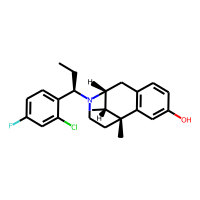

In [23]:
mydata = pd.read_csv('inhouse_chemprop_random_nocanonical.csv')
mydata.head(1)
PandasTools.AddMoleculeColumnToFrame(mydata,'Smile','Molecule')
mydata[["Smile","Molecule"]].head(1)

In [24]:
mydata["FPs"] = mydata.Molecule.apply(mol2fp)
my_x = np.stack(mydata.FPs.values)
#y = data.Label.values.reshape((-1,1))

In [25]:
my_x = feature_select.transform(my_x)
my_x = torch.FloatTensor(my_x)
my_xx = my_x.to(device)

In [26]:
model.eval()
my_y_preds = model(my_xx)
scores = torch.sigmoid(my_y_preds)
#my_scores = torch.sigmoid(my_y_preds).detach().cpu().numpy()

In [27]:
my_scores = torch.sigmoid(my_y_preds).detach().cpu().numpy()
mydata['Score']=my_scores

In [28]:
mydata_check=mydata.sort_values('Score')
PandasTools.SaveXlsxFromFrame(mydata_check,'inhouse_122_0127inhousecode.xlsx',molCol='Molecule')